## `FeedforwardNeuralNetwork` class

In the following code block, you can find a template for the class `FeedforwardNeuralNetwork` that implements a feedforward neural network
$$
	\begin{aligned}
		{\rm NN}  & : \mathbb{R}^{d} \to \mathbb{R}^{p}, \\
		{\rm NN} (x,y) & = \mathbf{A} \cdot F_{L} \circ \ldots \circ F_{1} (x,y)
	\end{aligned}
$$
with 
$$
	\begin{aligned}
		F_i : \mathbb{R}^{n_{i-1}} & \to \mathbb{R}^{n_{i}}, \\
		\mathbf{x}_{i} & = \sigma\left( \mathbf{W}_i \mathbf{x}_{i-1} + \mathbf{b}_i \right).
	\end{aligned}
$$
for $i=1,\ldots,L$. Here, $\mathbf{W}_i \in \mathbb{R}^{n_{i} \times n_{i-1}}$ ($n_0 \coloneqq d$), $\mathbf{b}_i \in \mathbb{R}^{n_{i}}$, $\mathbf{A} \in \mathbb{R}^{p \times n_L}$, and $\sigma\left(x\right)$ is the activation function, which is applied element-wise.

The implementations of the methods of this class are missing an have to be filled in.

### **Part 1**

#### (a)

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import random

class FeedforwardNeuralNetwork:

    def __init__(self, layer_sizes):
        """
        Initialize the feedforward neural network.
        
        Parameters:
        layer_sizes (list): List containing the number of neurons in each layer.
        """

        # Layer sizes include input and output layer sizes 
        self.layer_sizes = layer_sizes  
        self.num_layers = len(layer_sizes)
        
        # Initialize weights and biases with empty arrays
        # We use np.array instead of lists as later it will facilitate update operations
        self.weights = np.empty( (self.num_layers-1, ), dtype=object)
        self.biases = np.empty( (self.num_layers-2, ), dtype=object)
        
        # Loop through the hidden layers
        for l in range(1,self.num_layers-1):    
            
            # Initialize the weights with uniform distribution, as seen in the lecture notes
            self.weights[l-1] = np.random.uniform( -1/np.sqrt(layer_sizes[l]), +1/np.sqrt(layer_sizes[l]) ,size=(layer_sizes[l], layer_sizes[l-1]))

            # Initialize biases at zero
            self.biases[l-1] = np.zeros((layer_sizes[l],1))

        # Last weights (matrix A)
        self.weights[-1] = np.random.uniform( -1/np.sqrt(layer_sizes[-2]), +1/np.sqrt(layer_sizes[-2]), size=(layer_sizes[-1], layer_sizes[-2]))
        
    def activation(self, z):
        """
        Activation function.
        
        Parameters:
        z (numpy.ndarray): Input array.
        
        Returns:
        numpy.ndarray: Output array after applying the activation function.
        """
        # By default use ReLU activation. The activation function can be however replaced by 
        # assigning self.activation to a different function
        return z * (z > 0) # ReLU

    def activation_derivative(self, z):
        """
        Derivative of the activation function.
        
        Parameters:
        z (numpy.ndarray): Input array.
        
        Returns:
        numpy.ndarray: Output array after applying derivative of the activation function.
        """

        # Derivative of ReLU
        return 1. * (z > 0) 

    def feedforward(self, x):
        """
        Perform a feedforward pass through the network.
        
        Parameters:
        x (numpy.ndarray): Input array.
        
        Returns:
        numpy.ndarray: Output of the network.
        """

        # x is a single datapoint. Make sure it has the right dimensions and reshape to a column vector
        x = x.reshape((len(x), 1))

        # save activations of layers (a) for backpropagation
        self.a = [ x ]

        # save weighted inputs of layers (z) for backpropagation
        self.z = []       
        
        # Loop through the hidden layers
        for l in range(1,self.num_layers-1):

            # Compute and save z^(l) = W^(l)*a^(l-1) + b^(l)
            self.z.append( self.weights[l-1] @ self.a[-1] + self.biases[l-1] ) 

            # Compute and save a^(l) = activation(z^(l))
            self.a.append( self.activation(self.z[-1]))
            
        #Lastly, multiply by matrix A and return
        return self.weights[-1] @ self.a[-1]

    def compute_cost(self, y_pred, y_train):
        """
        Compute the cost function.
        
        Parameters:
        y_pred (numpy.ndarray): Predicted labels.
        y_train (numpy.ndarray): True labels.
        
        Returns:
        float: Cost value.
        """
        # At every epoch compute loss on the whole dataset
        # MSE Loss
        return ((y_pred - y_train)**2).sum()/y_pred.shape[0]
    
    def backpropagate(self, x, error,verbose=False):
        """
        Perform backpropagation to compute gradients.
        
        Parameters:
        x (numpy.ndarray): Input array.
        error (numpy.ndarray): Error array.
        
        Returns:
        tuple: Gradients of weights and biases.
        """

        # Compute the quantity d^(L) := dC/dz^(L)
        d = ( 2*error.transpose() @ self.weights[-1]) * self.activation_derivative(self.z[-1]).transpose()

        # Initialize the gradient arrays for weights and biases
        # Compute and add the gradients for the last layer
        nabla_w = [ d.transpose() @ self.a[-2].transpose()]
        nabla_b = [ d.transpose() ]

        # Loop through the hidden layers except for the last one, for which we have already computed the gradients
        for l in reversed(range(1,self.num_layers-2)):

            # Compute the quantity d^(l) := dC/dz^(l) using the recursive formula that involves d^(l+1)
            d = (d @ self.weights[l - 1 + 1]) * self.activation_derivative(self.z[l-1]).transpose()

            # Compute gradients for the current layer and save to array
            nabla_w.insert(0, d.transpose() @ self.a[l-1].transpose()) 
            nabla_b.insert(0, d.transpose())

        # Compute the gradient of the matrix A
        nabla_w.append( 2*error @ self.a[-1].transpose())  

        # Transform the lists into numpy arrays, as later it will facilitate update operations
        grads_w = np.empty( (len(nabla_w),), dtype=object)
        grads_b = np.empty( (len(nabla_b),), dtype=object)
        grads_w[...] = nabla_w
        grads_b[...] = nabla_b

        # return gradients arrays
        return (grads_w, grads_b)
     
    def update_parameters(self, nabla_w, nabla_b, learning_rate, beta, zeta):
        """
        Update the weights and biases using the computed gradients.
        
        Parameters:
        nabla_w (np.ndarray (dtype=object)): Gradients of weights.
        nabla_b (np.ndarray (dtype=object)): Gradients of biases.
        learning_rate (float): Learning rate.
        beta (float): Beta parameter (ADAM)
        zeta (float): Zeta parameter (ADAM)
        """
 
        # Implementation of ADAM, as explained in the lecture notes

        # Update u vectors 
        self.u_w = zeta*self.u_w + (1-zeta)*(nabla_w**2)
        self.u_b = zeta*self.u_b + (1-zeta)*(nabla_b**2)

        # Update v vectors 
        self.v_w = beta*self.v_w + (1 - beta)*nabla_w
        self.v_b = beta*self.v_b+ (1 - beta)*nabla_b

        # Compute alpha^(k)
        alpha = learning_rate*np.sqrt(1 - zeta**(self.k+1))/(1 - beta**(self.k+1))

        # Update weights and biases
        self.weights -= (alpha/( (self.u_w + 10**(-7))**0.5 ))*nabla_w
        self.biases -= (alpha/( (self.u_b + 10**(-7))**0.5 ))*nabla_b

        # Update iteration index
        self.k += 1

    def train(self, x_train, y_train, epochs, learning_rate, batch_size,adam_params=(0.9,0.999),verbose=False):
        """
        Train the neural network using mini-batch gradient descent with early stopping.
        
        Parameters:
        x_train (numpy.ndarray): Training data.
        y_train (numpy.ndarray): Training labels.
        epochs (int): Number of epochs.
        learning_rate (float): Learning rate.
        batch_size (int): Size of each mini-batch.
        """

        # Randomly shuffle indices of datapoints
        indices = list(range(len(y_train)))
        random.shuffle(indices)

        # Create batches using shuffled indices
        batches = [
            (x_train[i:i + batch_size], y_train[i:i + batch_size]) 
            for i in range(0, len(indices), batch_size)
        ]

        # Initialize ADAM variables
        self.k = 0
        self.u_w = np.zeros( (len(self.weights), ), dtype=object)
        self.u_b = np.zeros( (len(self.biases), ), dtype=object) 
        self.v_w = np.zeros( (len(self.weights), ), dtype=object)
        self.v_b = np.zeros( (len(self.biases), ), dtype=object)

        # Initialize losses vector
        losses = []

        # Iterate through epochs
        # One epoch is defined as the number of steps until all training data has been used once
        for epoch in range(epochs):

            # Use all training data, perform one step for each batch
            for b in range(len(batches)):

                # Select the current batch
                x_batch, y_batch = batches[b]
            
                # Initialize grad variables
                nabla_w = np.zeros( (len(self.weights),), dtype=object)
                nabla_b = np.zeros( (len(self.biases),), dtype=object)

                # Iterate through the datapoints in the batch
                for i in range(len(x_batch)):
        
                    # Perform feedforward and compute error
                    error = self.feedforward(x_batch[i]) - y_batch[i]

                    # Perform backpropagation and compute partial gradients 
                    p_nabla_w, p_nabla_b = self.backpropagate(x_batch[i], error)

                    # Add partial gradients to final gradients. The resulting
                    # gradients nabla_w, nabla_b are the gradients of the MSE 
                    # loss of the batch
                    nabla_w += p_nabla_w/float(x_batch.shape[0])
                    nabla_b += p_nabla_b/float(x_batch.shape[0])
            
                #Update parameters
                self.update_parameters(nabla_w,nabla_b,learning_rate, adam_params[0], adam_params[1])

            #Make predictions on the whole dataset
            y_pred = np.zeros(y_train.shape)
            for i in range(len(x_train)):
                y_pred[i] = self.feedforward(x_train[i])

            # Compute loss on the whole dataset and print it
            cost = self.compute_cost(y_pred, y_train)
            losses.append(cost)

            if(verbose):
                print("Epoch: {}/{} |  Cost: {}".format(epoch,epochs,cost))

        return losses
                

#### Train a network to learn the solution to the problem

$\quad \quad -\Delta u(x,y) = 2a\pi^2\sin(\pi x)\sin(\pi y) \quad$ in $\Omega$

$\quad \quad u(x,y) = 0 \quad $ on $\partial \Omega$

where $u(x,y) = a\sin(\pi x)\sin(\pi y) + b $ $\quad$ with $a=1$ and $b=0$


In [105]:
# Create the dataset
samples = 1000

# Function to approximate: a*sin(pi * x) * sin(pi * y) + b
def u_exact(a,b, x, y):
    return a*np.sin(np.pi * x) * np.sin(np.pi * y) + b

# Generate training data
x_train = np.random.rand(samples, 2)  # Random samples in [0, 1]
y_train = u_exact(1,0,x_train[:, 0], x_train[:, 1]).reshape(-1, 1)


In [106]:
# Functions for normalizing and denormalizing the dataset (min - max scaling)
def normalize (x):
    m = x.min()
    M = x.max()
    x = (x - m) / (M - m)

    return [x, m, M]

def denormalize (x, m, M):
    return x * (M - m) + m

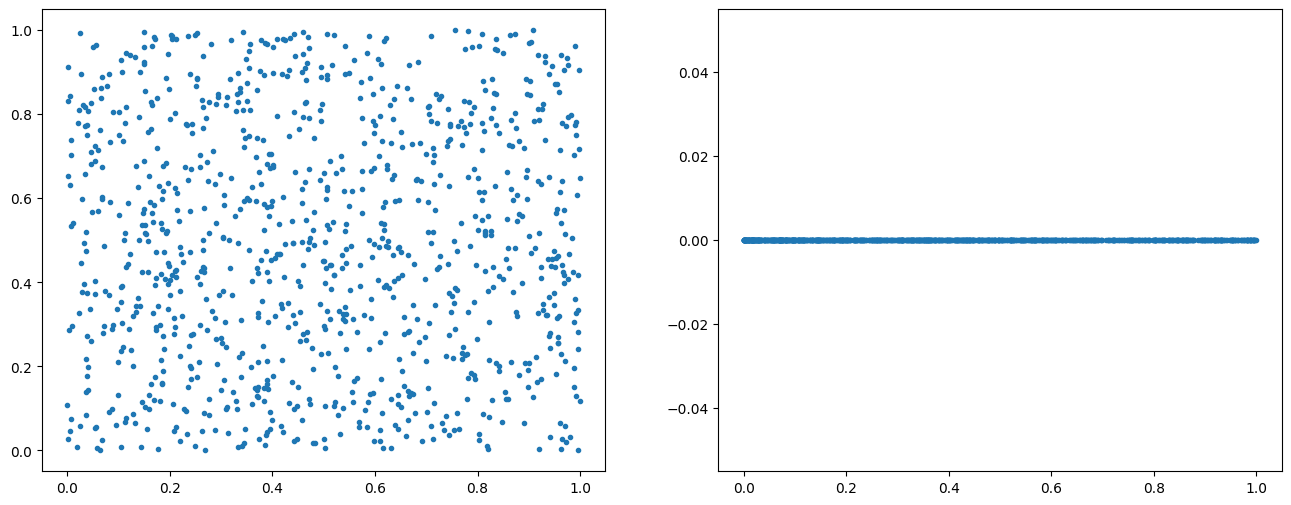

In [107]:
# Scatterplot of x_train and y_train
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].scatter(x_train[:,0], x_train[:,1],marker='.')
axes[1].plot(y_train, [0 for i in range(len(y_train))],'.')


As we can see from the plots the data is already evenly distributed between 0 and 1 (as expected) thus in this case there is no need for normalization

In [108]:
nn = FeedforwardNeuralNetwork([2,32,32,32,32,32,1])

In [109]:
losses = nn.train(x_train,y_train,200,0.00003,1,verbose=True)

Epoch: 0/200 |  Cost: 0.15676827685504358
Epoch: 1/200 |  Cost: 0.09098625198291962
Epoch: 2/200 |  Cost: 0.08963220664099666
Epoch: 3/200 |  Cost: 0.08852474783734994
Epoch: 4/200 |  Cost: 0.08718627164642316
Epoch: 5/200 |  Cost: 0.08586156703267835
Epoch: 6/200 |  Cost: 0.08439925823699863
Epoch: 7/200 |  Cost: 0.08272578839896776
Epoch: 8/200 |  Cost: 0.08080284071744791
Epoch: 9/200 |  Cost: 0.07835312526027041
Epoch: 10/200 |  Cost: 0.07570711483919157
Epoch: 11/200 |  Cost: 0.0728647723651298
Epoch: 12/200 |  Cost: 0.06994972611583149
Epoch: 13/200 |  Cost: 0.06708342148267236
Epoch: 14/200 |  Cost: 0.0643726936908879
Epoch: 15/200 |  Cost: 0.061747000210382576
Epoch: 16/200 |  Cost: 0.059022667890068506
Epoch: 17/200 |  Cost: 0.0562526895719331
Epoch: 18/200 |  Cost: 0.05318577045373283
Epoch: 19/200 |  Cost: 0.049904357667388426
Epoch: 20/200 |  Cost: 0.04621585326963569
Epoch: 21/200 |  Cost: 0.04203383846879753
Epoch: 22/200 |  Cost: 0.037414790090523384
Epoch: 23/200 |  Cos

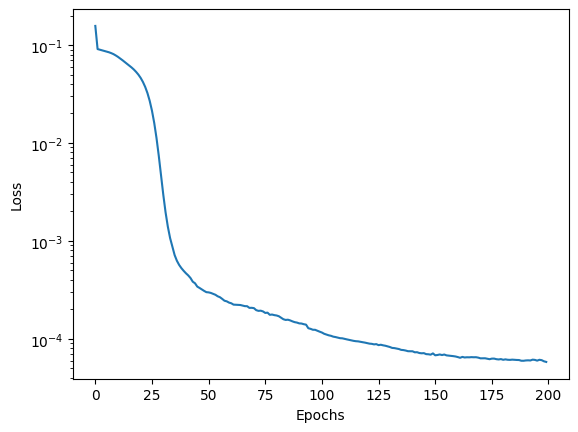

In [110]:
# Plot the loss as a function of the epochs
plt.semilogy([i for i in range(200)], losses)
plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.show()

/tmp/ipykernel_688158/634561133.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ypred[i] = nn.feedforward(x_test[i])


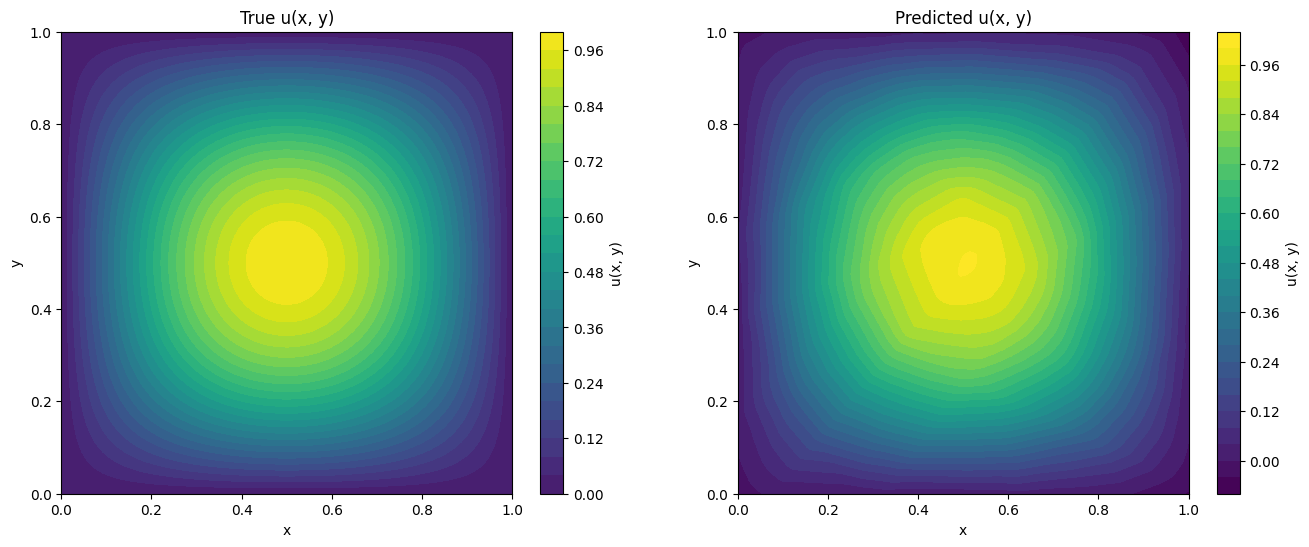

In [111]:
# Visualize the results on a test grid and compare with the exact solution

# 100 x 100 test grid
testsize = 100

# Coordinates of the gridpoints
y_coords = x_coords = np.linspace(0, 1, testsize)

# Test_dataset
x_test = np.array([[x, y] for x in x_coords for y in y_coords])
y_test = u_exact(1,0,x_test[:,0], x_test[:,1])

# Reshape as a grid
y_test_grid = y_test.reshape(testsize, testsize)


X, Y = np.meshgrid(x_coords, y_coords)

ypred = np.zeros(y_test.shape)
for i in range(len(ypred)):
    ypred[i] = nn.feedforward(x_test[i])

ypred_grid = ypred.reshape(testsize, testsize)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# True u(x, y) values
c1 = axes[0].contourf(X, Y, y_test_grid, cmap="viridis", levels=30)
fig.colorbar(c1, ax=axes[0], label="u(x, y)")
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
axes[0].set_title("True u(x, y)")

# Predicted u(x, y) values
c2 = axes[1].contourf(X, Y, ypred_grid, cmap="viridis", levels=30)
fig.colorbar(c2, ax=axes[1], label="u(x, y)")
axes[1].set_xlabel("x")
axes[1].set_ylabel("y")
axes[1].set_title("Predicted u(x, y)")

# Ensure both plots share the same color scale
c1.set_clim(vmin=min(y_test.min(), ypred.min()), vmax=max(y_test.max(), ypred.max()))
c2.set_clim(vmin=min(y_test.min(), ypred.min()), vmax=max(y_test.max(), ypred.max()))

#### (b)

Perform grid search with cross validation to optimize hyper parameters.

In [84]:
# Create cross validation dataset
x_cv = np.random.rand(500, 2)  # Random samples in [0, 1]
y_cv = u_exact(1,0,x_cv[:, 0], x_cv[:, 1]).reshape(-1, 1)

Let's initially perform a coarse grid search with just three activation functions and two types of architecture.

In [305]:
# Activation functions

ReLu = lambda z : z * (z > 0)
ReLu_prime = lambda z : 1.* (z > 0)

tan_h = lambda z : (np.exp (2*z) - 1) / (np.exp (2*z) + 1)
tan_h_prime = lambda z : 1 - tan_h(z)**2

sigmoid = lambda z : 1/(1+np.exp(-z))
sigmoid_prime = lambda z : 1 / (1 + np.exp (z))

activations = [ReLu, tan_h, sigmoid]
activations_prime = [ReLu_prime, tan_h_prime, sigmoid_prime]

We use two types of architectures that have, more or less, the same number of weights, but that differ in the structure.

The architectures we choose are:

- [2, 32, 32, 32, 32, 32, 1]: increased depth while maintaining a moderate number of neurons to prevent overfitting. Each layer refines the learned features. (Number of weights 4192)

- [2, 64, 64, 1]: wider layers for capturing detailed patterns in data. Appropriate for complex tasks with significant input variation. (Number of weights 4288)

In [306]:
# Two different network architectures, with roughly the same number of weights:
architectures = [ [2, 32, 32, 32, 32, 32, 1], [2, 64, 64, 1] ] 

Now we fix the other hyperparameters such as learning rate to 0.001, epochs to 600, batch size to 64 and ADAM parameters to (0.9, 0.999) and understand which combination between architecture and activation function works better.

In [287]:
# Loop through activation functions
for j in range (3):
    
    # Loop through architectures
    for layer_sizes in architectures:
        loss = 0
        
        # Repeat 3 times to compensate for random initialization
        for r in range (3):

            nn = FeedforwardNeuralNetwork(layer_sizes)
            nn.activation = activations[j]
            nn.activation_derivative = activations_prime[j]
            nn.train(x_train, y_train, 600, 0.001, 64, (0.9,0.999))

            y = np.zeros((x_cv.shape[0],1))
            for k in range (x_cv.shape[0]):
                y[k] = nn.feedforward (x_cv[k,:])

            loss += nn.compute_cost (y_cv, y)/3

                    
        print ( "Activation: {}, Architecture: {}, Loss: {}".format(['relu','tanh','sigmoid'][j], layer_sizes, loss) )

Activation: relu, Architecture: [2, 32, 32, 32, 32, 32, 1], Loss: 0.0004962296830054871
Activation: relu, Architecture: [2, 64, 64, 1], Loss: 0.000576708453746908
Activation: tanh, Architecture: [2, 32, 32, 32, 32, 32, 1], Loss: 0.001329319616555867
Activation: tanh, Architecture: [2, 64, 64, 1], Loss: 0.0011906525271171476
Activation: sigmoid, Architecture: [2, 32, 32, 32, 32, 32, 1], Loss: 0.07626141184777213
Activation: sigmoid, Architecture: [2, 64, 64, 1], Loss: 0.06330903690177105


It can be noticed that neural networks with ReLU as an activation function consistently outperform those with tanh or sigmoid. Therefore for our next considerations we are going to use only ReLu as activation function.

Concerning the architecture, there is no evident difference between performances, however [2, 32, 32, 32, 32, 32, 1] seems to perform better when using ReLu, thus we prefer to focus on this type of architecture.

We now perform a finer grid search also varying learning rate, epochs, batch size and ADAM parameters $\zeta$ and $\beta$

**Learning Rate**

We know that the learning rate determines how much the weights of the neural network change during each step of training. A smaller learning rate means the network updates more cautiously, while a larger learning rate allows faster progress. We choose the following values:

In [290]:
learning_rates = [ 0.001, 0.0005, 0.0001 ]

**Batch Size**

A smaller batch size allows for a faster update with large datasets and it may generalize well, however it might lead to oscillations of the cost function. On the other hand, using the whole dataset as batch may avoid oscillations, but it might be computationally inefficient with large datasets and there may be the risk of not finding the local minimum. We choose three vaues on a logarithmic scale based on the size of the dataset

In [291]:
batch_sizes = [ int(samples**(1/3)), int(samples**(2/3)), samples ]

**Epochs**

As seen in previous trainings, after around 600 iteration the loss already reaches a low value. However, in order to allow for smaller learning rates to converge, we experiment with higher epochs number. 

In [292]:
epochs = [600, 1200, 3600]

**ADAM Parameters**

$\beta$ helps smooth the updates by combining information from previous steps, while $\zeta$ controls how past gradients are remembered to stabilize the learning rate.


In [293]:
betas = [0.85, 0.9]
zetas = [0.95, 0.999]

In [294]:
# Save the combinations to file
import pickle

# Keep track of the combinations
combinations = []

for ep in epochs:

    for lr in learning_rates:

        for batch_size in batch_sizes:

            for beta in betas:

                for zeta in zetas:
                    
                    nn = FeedforwardNeuralNetwork([2, 32, 32, 32, 32, 32, 1])
                    nn.train(x_train, y_train, ep, lr, batch_size, adam_params=(beta, zeta))

                    y = np.zeros((x_cv.shape[0],1))
                    for k in range (x_cv.shape[0]):
                        y[k] = nn.feedforward (x_cv[k,:])

                    loss = nn.compute_cost (y_cv, y)

                    print(" Epochs: {} Learning rate: {} Batch size: {} Beta: {} Zeta: {} Loss: {}".format(ep,lr,batch_size,beta,zeta,loss))
                    combinations.append( (ep,lr,batch_size,beta,zeta,loss) )

pickle.dump(combinations, open("combinations.dat","wb"))     

 Epochs: 600 Learning rate: 0.001 Batch size: 9 Beta: 0.85 Zeta: 0.95 Loss: 0.000359454716540693
 Epochs: 600 Learning rate: 0.001 Batch size: 9 Beta: 0.85 Zeta: 0.999 Loss: 0.0007445844181328723
 Epochs: 600 Learning rate: 0.001 Batch size: 9 Beta: 0.9 Zeta: 0.95 Loss: 9.135692955938301e-05
 Epochs: 600 Learning rate: 0.001 Batch size: 9 Beta: 0.9 Zeta: 0.999 Loss: 3.876514045432121e-05
 Epochs: 600 Learning rate: 0.001 Batch size: 99 Beta: 0.85 Zeta: 0.95 Loss: 0.0009073528970176679
 Epochs: 600 Learning rate: 0.001 Batch size: 99 Beta: 0.85 Zeta: 0.999 Loss: 0.0003156389989517934
 Epochs: 600 Learning rate: 0.001 Batch size: 99 Beta: 0.9 Zeta: 0.95 Loss: 0.0004054568898918396
 Epochs: 600 Learning rate: 0.001 Batch size: 99 Beta: 0.9 Zeta: 0.999 Loss: 0.00039034203407092155
 Epochs: 600 Learning rate: 0.001 Batch size: 1000 Beta: 0.85 Zeta: 0.95 Loss: 0.0030161838208314813
 Epochs: 600 Learning rate: 0.001 Batch size: 1000 Beta: 0.85 Zeta: 0.999 Loss: 0.0015823342064684492
 Epochs: 

From the grid search we can see that a smaller batch size generally results in lower cost function. It is also worth noting that a higher number of epochs does not necessarily result in a lower cost: for example, even with 600 epochs, some models were able to reach an MSE of order 10^(-5). We also wish to investigate which combination of of $\beta$ and $\zeta$ yielded the best results.

In [45]:
# Load combinations from file, avoiding to re run the grid search again
import pickle

combinations = pickle.load(open("combinations.dat","rb"))

In [69]:
# Convert to np.array
combinations = np.array(combinations)

In [70]:
# Consider only the combinations where the batch size is 9
combinations2 = combinations[ combinations[:,2] == 9]


In [71]:
# Get the losses
losses = combinations2[:,5]

In [72]:
# Reshape so that each column corresponds to the losses of a specific combination of beta and zeta

# 1: 0.85, 0.95
# 2: 0.85, 0.999
# 3: 0.9, 0.95
# 4: 0.9, 0.999

losses = losses.reshape(9,4)
losses

array([[3.59454717e-04, 7.44584418e-04, 9.13569296e-05, 3.87651405e-05],
       [1.39402671e-04, 1.74374544e-04, 4.99700074e-04, 4.64757285e-04],
       [8.68793331e-04, 3.23567963e-05, 1.40912019e-04, 4.90259805e-05],
       [5.78722964e-04, 8.52921040e-05, 1.63577180e-04, 1.53614014e-04],
       [2.95980968e-04, 7.67488409e-05, 3.38046974e-04, 3.44389555e-04],
       [2.86849064e-05, 1.06869764e-04, 1.37594372e-03, 3.47712067e-05],
       [2.28750474e-05, 1.74841045e-05, 8.15418330e-05, 3.13645864e-05],
       [1.54107792e-04, 9.98358409e-06, 1.44538170e-04, 1.50545555e-05],
       [7.50257439e-05, 8.82159432e-05, 1.94953755e-04, 6.46999851e-05]])

In [73]:
# Compute the average of each column
losses.mean(axis=0)

array([0.00028034, 0.00014843, 0.00033673, 0.00013294])

As we can see, the combination  $\beta=0.9$ $\zeta=0.999$  yields better results for smaller batch sizes.

This motivates us to perform a further grid search limiting epochs at 500 and using smaller batch sizes, keeping $\beta=0.9$ $\zeta=0.999$ and varying the learning rate. This time the train loss graph will also be printed, in order to understand how batch size and learning rate affect oscillations in the loss function. 

Batch size: 1 Learning rate: 1e-05 CV Loss: 7.418597450278478e-05


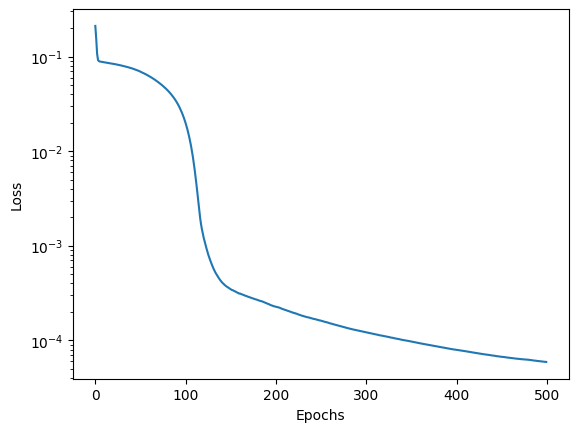

Batch size: 1 Learning rate: 5e-05 CV Loss: 3.996550784192284e-05


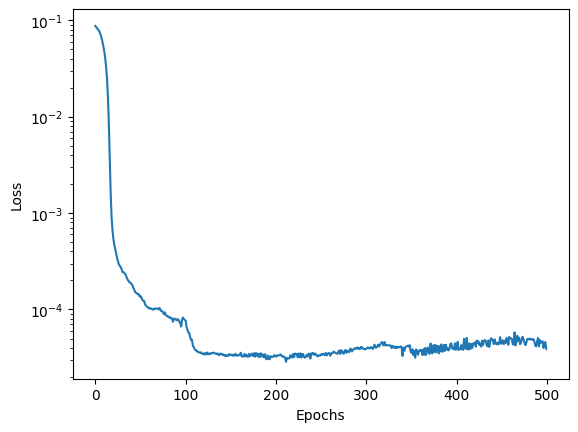

Batch size: 1 Learning rate: 0.0001 CV Loss: 8.518137170227791e-05


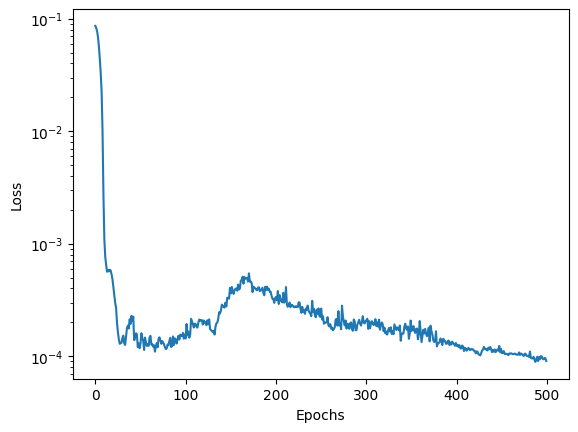

Batch size: 1 Learning rate: 0.0005 CV Loss: 9.077720990372387e-05


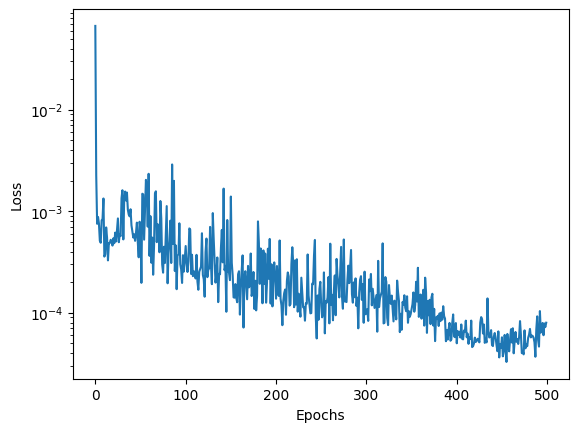

Batch size: 1 Learning rate: 0.001 CV Loss: 6.513321244685454e-05


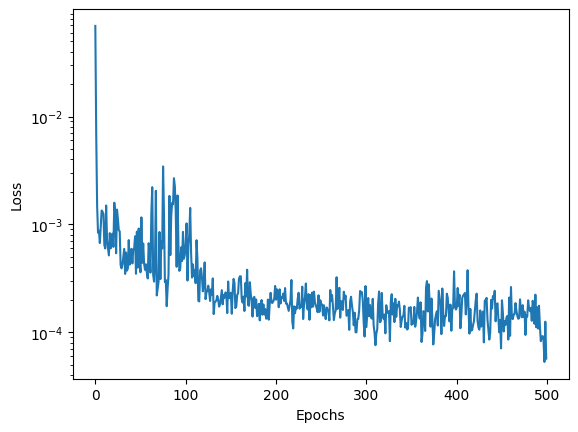

Batch size: 3 Learning rate: 1e-05 CV Loss: 0.00016698194081186287


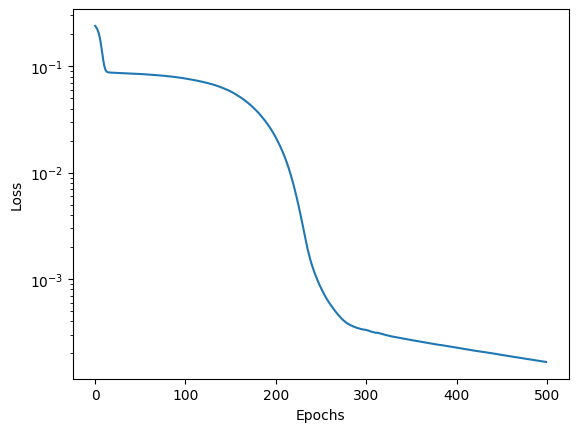

Batch size: 3 Learning rate: 5e-05 CV Loss: 0.00032625555662326355


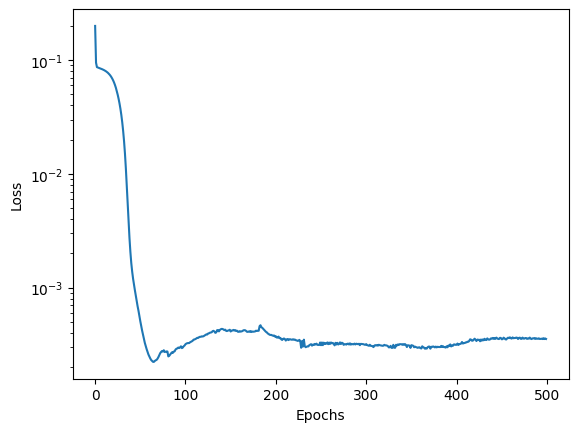

Batch size: 3 Learning rate: 0.0001 CV Loss: 0.00014946861665255079


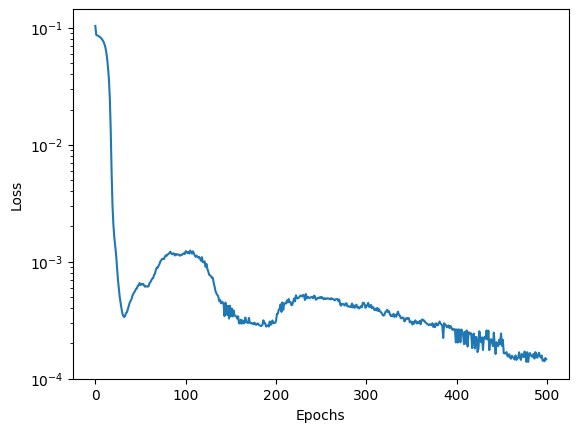

Batch size: 3 Learning rate: 0.0005 CV Loss: 9.965835443272827e-05


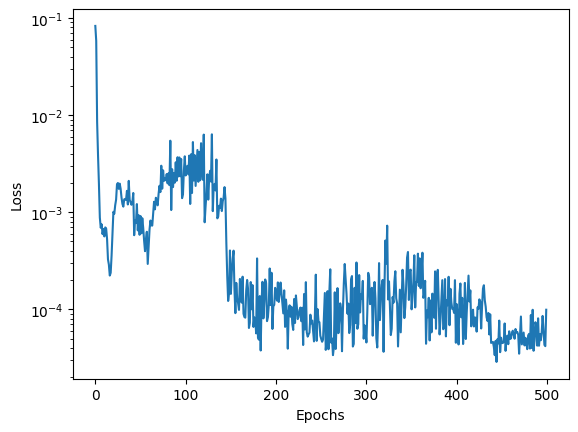

Batch size: 3 Learning rate: 0.001 CV Loss: 5.525529896176676e-05


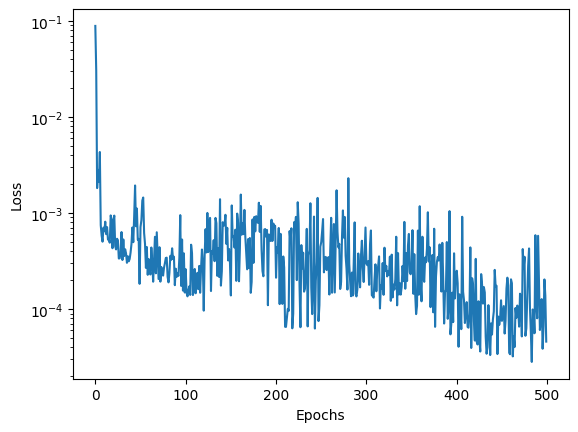

Batch size: 5 Learning rate: 1e-05 CV Loss: 0.00033691633725938745


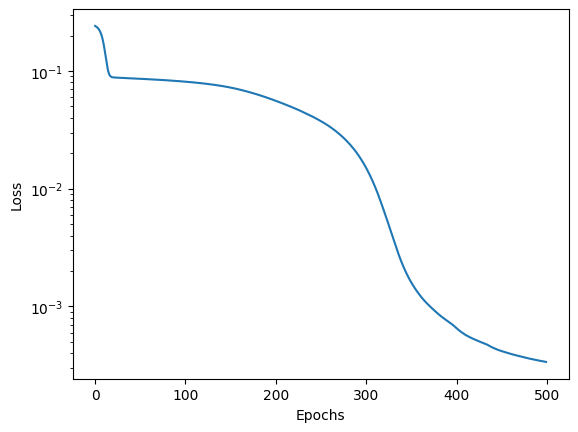

Batch size: 5 Learning rate: 5e-05 CV Loss: 8.941941217296421e-05


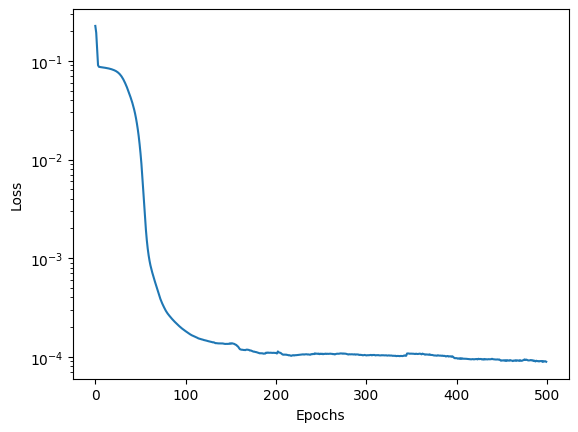

Batch size: 5 Learning rate: 0.0001 CV Loss: 9.802605327834929e-05


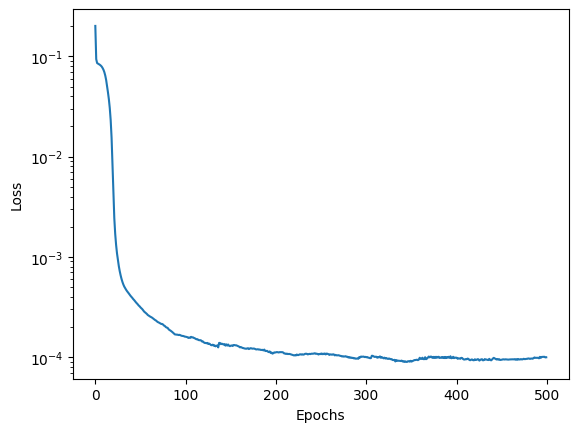

Batch size: 5 Learning rate: 0.0005 CV Loss: 5.235145217168112e-05


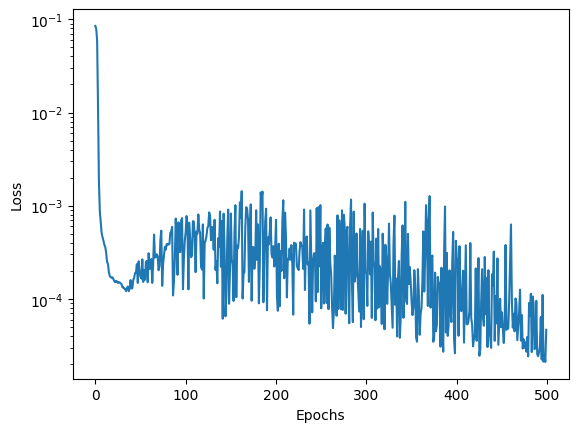

Batch size: 5 Learning rate: 0.001 CV Loss: 9.77671883337412e-05


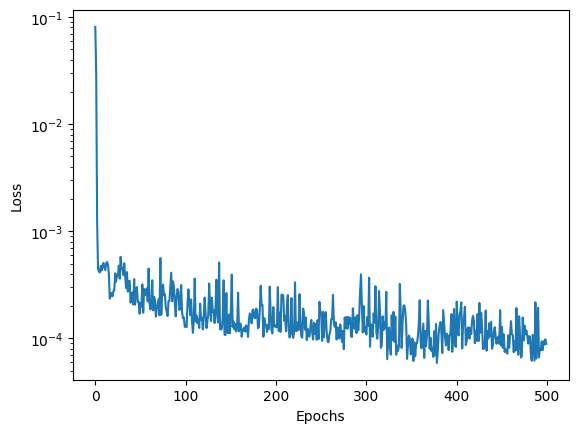

Batch size: 7 Learning rate: 1e-05 CV Loss: 0.00023161650551871632


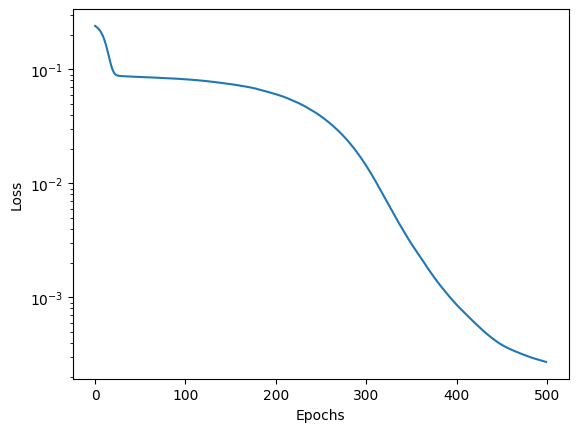

Batch size: 7 Learning rate: 5e-05 CV Loss: 5.804243292856945e-05


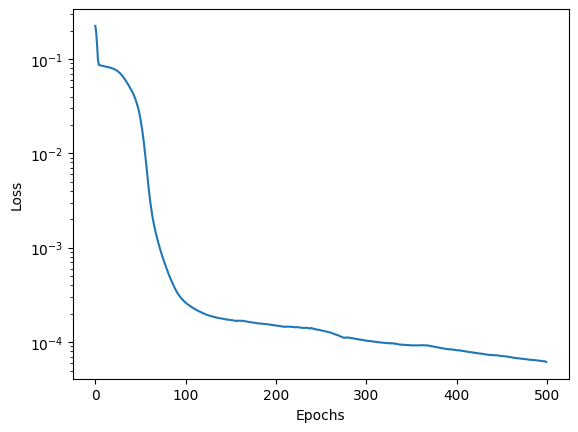

Batch size: 7 Learning rate: 0.0001 CV Loss: 5.095117001066727e-05


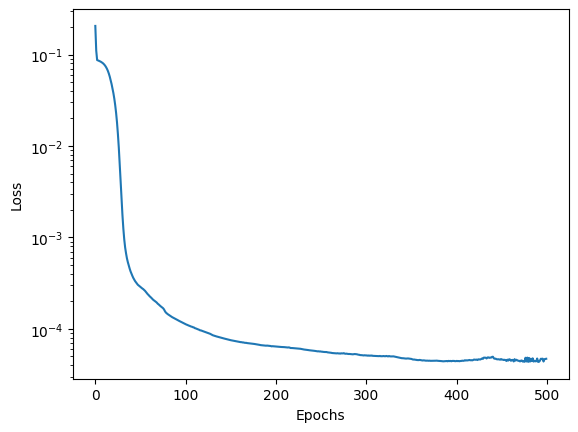

Batch size: 7 Learning rate: 0.0005 CV Loss: 0.00032053711462781996


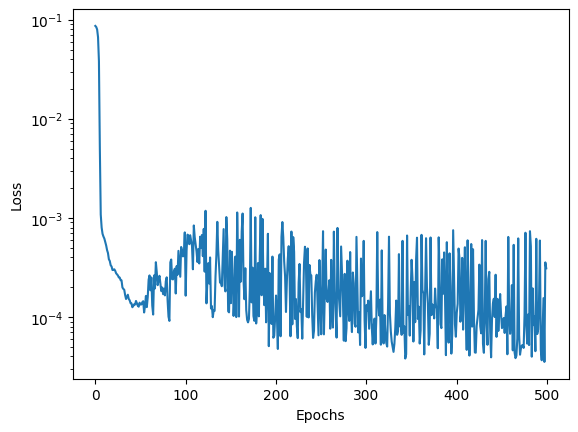

Batch size: 7 Learning rate: 0.001 CV Loss: 0.00018979658020124512


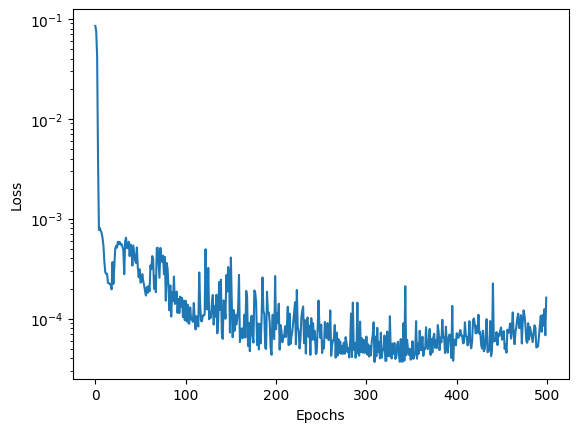

Batch size: 9 Learning rate: 1e-05 CV Loss: 0.0004435317311540168


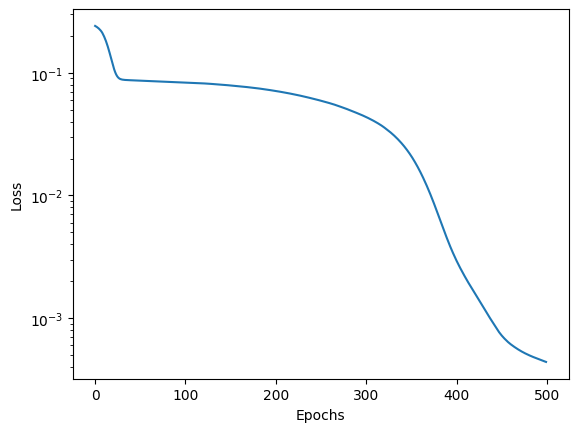

Batch size: 9 Learning rate: 5e-05 CV Loss: 6.574051288545054e-05


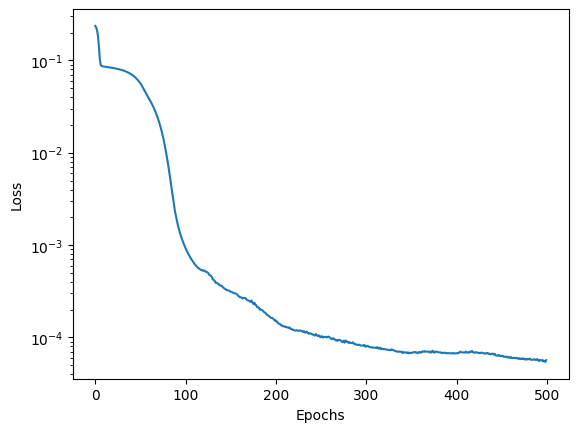

Batch size: 9 Learning rate: 0.0001 CV Loss: 4.0669038516385095e-05


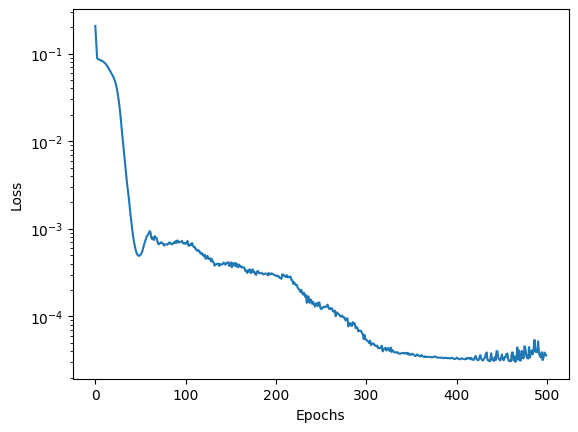

Batch size: 9 Learning rate: 0.0005 CV Loss: 7.010961844035703e-05


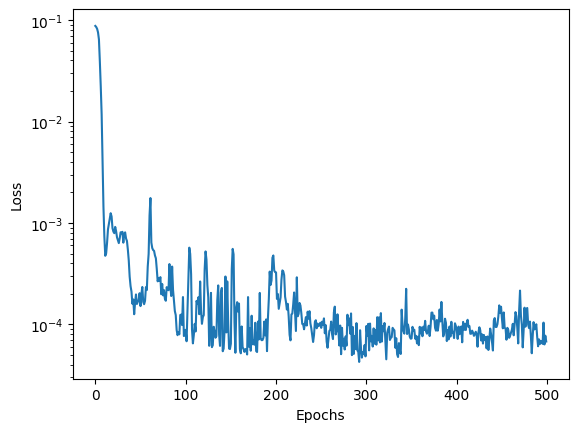

Batch size: 9 Learning rate: 0.001 CV Loss: 0.00016637115396156353


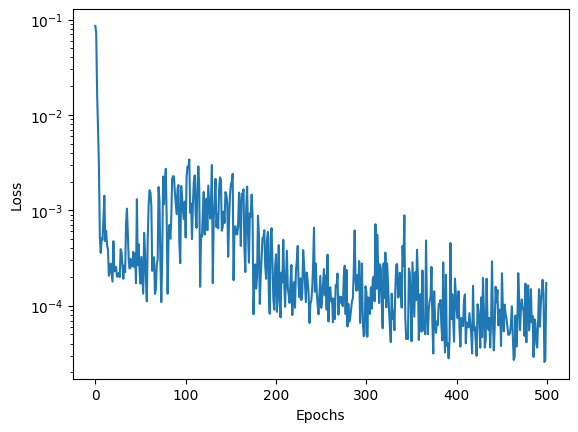

In [86]:
for batch_size in [1, 3, 5, 7, 9]:

    for learning_rate in [0.00001, 0.00005, 0.0001, 0.0005, 0.001]:

        nn = FeedforwardNeuralNetwork([2, 32, 32, 32, 32, 32, 1])
        losses = nn.train(x_train, y_train, 500, learning_rate, batch_size,(0.9,0.999))

        y = np.zeros((x_cv.shape[0],1))
        for k in range (x_cv.shape[0]):
            y[k] = nn.feedforward (x_cv[k,:])

        loss = nn.compute_cost (y_cv, y)
        print("Batch size: {} Learning rate: {} CV Loss: {}".format(batch_size, learning_rate, loss))
        plt.semilogy([i for i in range(500)], losses)
        plt.xlabel('Epochs'); plt.ylabel('Loss')
        plt.show()




As we can see, some combination of hyperparameters produce strong oscillations in the loss function, and the resulting model loss is highly fluctuating. We therefore prefer to choose parameters that produce a smooth loss function descent. Among these, choosing a batch size of 7 and a learning rate of 0.00005 appears to be the best choice. In conclusion, the best combination of hyperparameters that we found is 

- Epochs: 500
- Learning rate: 0.00005
- Batch size: 7
- $\beta=0.9$ 
- $\zeta=0.999$
- Architecture: [2,32,32,32,32,32,1]
- Activation function: ReLu

In [91]:
nn = FeedforwardNeuralNetwork([2, 32, 32, 32, 32, 32,1 ])
losses = nn.train(x_train, y_train, 500, 0.00005, 7,(0.9,0.999), verbose=True)

Epoch: 0/500 |  Cost: 0.23360139208469155
Epoch: 1/500 |  Cost: 0.21585811556460308
Epoch: 2/500 |  Cost: 0.18196820695851268
Epoch: 3/500 |  Cost: 0.12640462008626507
Epoch: 4/500 |  Cost: 0.09204104786032054
Epoch: 5/500 |  Cost: 0.08752907170107571
Epoch: 6/500 |  Cost: 0.0868530606959099
Epoch: 7/500 |  Cost: 0.08642921035017705
Epoch: 8/500 |  Cost: 0.08603650739482321
Epoch: 9/500 |  Cost: 0.08564408611220464
Epoch: 10/500 |  Cost: 0.08524134167499392
Epoch: 11/500 |  Cost: 0.08482222434527995
Epoch: 12/500 |  Cost: 0.08437903280703218
Epoch: 13/500 |  Cost: 0.08390891886953505
Epoch: 14/500 |  Cost: 0.08341078550044147
Epoch: 15/500 |  Cost: 0.08287433450915083
Epoch: 16/500 |  Cost: 0.08230130512991835
Epoch: 17/500 |  Cost: 0.08168254914378371
Epoch: 18/500 |  Cost: 0.08101467208053474
Epoch: 19/500 |  Cost: 0.08029467792379279
Epoch: 20/500 |  Cost: 0.07951316921347772
Epoch: 21/500 |  Cost: 0.07866470710907734
Epoch: 22/500 |  Cost: 0.07774397710394275
Epoch: 23/500 |  Cost:

#### (c)

Setup finite differences method solver

In [112]:
from ipynb.fs.full.fdm import PoissonSolver2D
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

# Define the boundary condition function
def boundary_func(x, y):
    return 0.0

# Define the source term function
def source_func(x, y):
    return 2.0 * np.pi**2 * np.sin(np.pi * x) * np.sin(np.pi * y)

# Define exact solution function
def analytical_soln(x, y):
    return np.sin(np.pi * x)*np.sin(np.pi * y)

def normalize (x):
    return (x - x.min())/(x.max()-x.min())

# Refinement of grid
Ref_array = np.linspace(10,100, 50).astype(int)
nx = Ref_array; ny = Ref_array

# Number of data points
N = nx*ny 

# lx, ly
lx= 1.0; ly = 1.0

Setup and train FNN

In [113]:
# Generate training data (1000 datapoints)
n_samples = 1000

# As seen previously, in this case normalization is not needed as
# data is already evenly distributed between 0 and 1  
x_train = np.random.rand(n_samples, 2)
y_train = u_exact(1,0,x_train[:, 0], x_train[:, 1]).reshape(-1, 1)

# Create an instance of the Neural Network with optimal architecture found in (b)
neural = FeedforwardNeuralNetwork([2,32,32,32,32,32,1])

losses = neural.train(x_train, y_train, 500, 0.00005, 7, verbose = True)

Epoch: 0/500 |  Cost: 0.2399055353513371
Epoch: 1/500 |  Cost: 0.2110901430237064
Epoch: 2/500 |  Cost: 0.1593961873430451
Epoch: 3/500 |  Cost: 0.10391840024859526
Epoch: 4/500 |  Cost: 0.08821477528432989
Epoch: 5/500 |  Cost: 0.08674792362216684
Epoch: 6/500 |  Cost: 0.08602502148852721
Epoch: 7/500 |  Cost: 0.08531963393045569
Epoch: 8/500 |  Cost: 0.08461390356141689
Epoch: 9/500 |  Cost: 0.08387160543861048
Epoch: 10/500 |  Cost: 0.08303804913357402
Epoch: 11/500 |  Cost: 0.08218389660059669
Epoch: 12/500 |  Cost: 0.08125890769670135
Epoch: 13/500 |  Cost: 0.08025051735920405
Epoch: 14/500 |  Cost: 0.07912028918801887
Epoch: 15/500 |  Cost: 0.07774287808621971
Epoch: 16/500 |  Cost: 0.07632074684664238
Epoch: 17/500 |  Cost: 0.07477420032940993
Epoch: 18/500 |  Cost: 0.07308431949511919
Epoch: 19/500 |  Cost: 0.07127200587486739
Epoch: 20/500 |  Cost: 0.06932744465157359
Epoch: 21/500 |  Cost: 0.06726518347931926
Epoch: 22/500 |  Cost: 0.06507691439870474
Epoch: 23/500 |  Cost: 0

Compare accuracies over different grid sizes

In [114]:
# Accuracy for the FDM and NN
accuracy_fdm = []
accuracy_nn = []

for n in np.arange(len(Ref_array)):
    solver = PoissonSolver2D(nx[n], ny[n], lx, ly)
    solver.set_boundary_conditions(boundary_func)
    solver.set_source_term(source_func)
    solver.setup_linear_system()
    solver.solve()

    # Get the test grid
    test_grid = solver.get_meshgrid()

    # Reshape to fit into the neural network
    coordinates = normalize(np.stack([test_grid[0].ravel(), test_grid[1].ravel()], axis = -1))

    # Generate exact solution
    u_ex = analytical_soln(coordinates.T[0], coordinates.T[1])

    # Approximate solution with Finite Difference Solver
    u_fdm = solver.get_solution().flatten()

    # Approximate solution with trained Neural Network
   
    u_nn = np.zeros(len(u_ex))
    for i in range(len(u_ex)):
        u_nn[i] += neural.feedforward(coordinates[i])

    # Compute accuracy of NN approximation (MSE)
    accuracy_nn.append(neural.compute_cost(u_nn, u_ex))

    # Compute accuracy of FDM approximation (MSE)
    accuracy_fdm.append(((u_fdm - u_ex)**2).sum()/(u_ex.shape[0]))

print('Average MSE for the Neural network approximation: {}'.format(np.mean(accuracy_nn)))


/tmp/ipykernel_688158/500971873.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_nn[i] += neural.feedforward(coordinates[i])


Average MSE for the Neural network approximation: 5.3519211356375056e-05


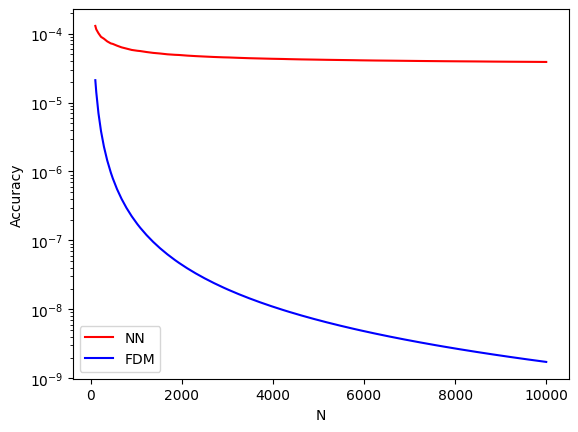

In [115]:
# Accuracy plot
plt.semilogy(N, accuracy_nn, 'r-', label = 'NN'); plt.semilogy(N, accuracy_fdm, 'b-', label = 'FDM')
plt.xlabel('N'); plt.ylabel('Accuracy')
plt.legend()
plt.show()

After training the Neural Network, the accuracy of its approximation is already predetermined. In that sense, it is logical that the accuracy of the Neural Network remains constant as a function of the number of test points. 